##Part 1: Import Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


##Part 2: Load and Explore the Data

In [ ]:
leads_df = pd.read_csv('Leads.csv')

In [ ]:
print("Dataset shape:", leads_df.shape)


Dataset shape: (9240, 37)


In [ ]:
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
print("Missing values in each column:\n", leads_df.isnull().sum())

Missing values in each column:
 Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                          

##Part 3: Data Cleaning

In [ ]:
# Replace placeholder values with NaN
leads_df.replace("Select", np.nan, inplace=True)

In [ ]:
missing_values = (leads_df.isnull().sum() / len(leads_df)) * 100
missing_values = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_values)

Columns with missing values:
 Lead Source                                       0.389610
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   36.580087
How did you hear about X Education               78.463203
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Tags                                             36.287879
Lead Quality                                     51.590909
Lead Profile                                     74.188312
City                                             39.707792
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Score

In [ ]:
missing_values40 = missing_values[missing_values > 40]
print("Columns with missing values:\n", missing_values40)

Columns with missing values:
 How did you hear about X Education    78.463203
Lead Quality                          51.590909
Lead Profile                          74.188312
Asymmetrique Activity Index           45.649351
Asymmetrique Profile Index            45.649351
Asymmetrique Activity Score           45.649351
Asymmetrique Profile Score            45.649351
dtype: float64


In [ ]:
# Drop columns with more than 40% missing values
missing_threshold = 0.4
columns_to_drop = leads_df.columns[leads_df.isnull().mean() > missing_threshold]
leads_df.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns with high missing values: {list(columns_to_drop)}")

Dropped columns with high missing values: ['How did you hear about X Education', 'Lead Quality', 'Lead Profile', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']


In [ ]:
categorical_cols = leads_df.select_dtypes(include=['object']).columns
categorical_cols

Index(['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Do Not Call', 'Last Activity', 'Country', 'Specialization',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [ ]:
for col in categorical_cols:
    if leads_df[col].isnull().sum() > 0:
        leads_df[col].fillna(leads_df[col].mode()[0], inplace=True)

<ipython-input-11-e5bc25dbf81f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  leads_df[col].fillna(leads_df[col].mode()[0], inplace=True)


In [ ]:
numerical_cols = leads_df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols

Index(['Lead Number', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit'],
      dtype='object')

In [ ]:
for col in numerical_cols:
    if leads_df[col].isnull().sum() > 0:
        leads_df[col].fillna(leads_df[col].median(), inplace=True)

<ipython-input-13-d54e8a7a838b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  leads_df[col].fillna(leads_df[col].median(), inplace=True)


In [ ]:
irrelevant_columns = ['Prospect ID', 'Lead Number']
leads_df.drop(columns=irrelevant_columns, errors='ignore', inplace=True)
print(f"Dropped irrelevant columns: {irrelevant_columns}")

Dropped irrelevant columns: ['Prospect ID', 'Lead Number']


In [ ]:
print("Remaining missing values:", leads_df.isnull().sum().sum())

Remaining missing values: 0


**Part 3A: Convert Binary Categorical Columns**

In [ ]:
binary_columns = [
    'Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article',
    'Receive More Updates About Our Courses', 'Through Recommendations',
    'Update me on Supply Chain Content', 'Get updates on DM Content',
    'I agree to pay the amount through cheque'
]

for col in binary_columns:
    if col in leads_df.columns:
        leads_df[col] = leads_df[col].map({'Yes': 1, 'No': 0})
    else:
        print(f"Warning: Column '{col}' not found.")

**Part 3B: Dummy Variable for Categorical Columns**

In [ ]:
# Create dummy variables for categorical columns with multiple levels
categorical_columns = leads_df.select_dtypes(include=['object']).columns
leads_df = pd.get_dummies(leads_df, columns=categorical_columns, drop_first=True)

# Verify dummy variable creation
print("Shape after dummy variable creation:", leads_df.shape)

Shape after dummy variable creation: (9240, 164)


Part3C: Combine Less Frequent Columns
**bold text**

In [ ]:
# Combine infrequent categories
threshold = 0.01
low_freq_cols = []

for col in leads_df.columns:
    if col.startswith('Lead Source_') and leads_df[col].sum() / len(leads_df) < threshold:
        low_freq_cols.append(col)

# Create a new column 'Lead Source_Others' for combined categories
leads_df['Lead Source_Others'] = leads_df[low_freq_cols].sum(axis=1)

# Drop low-frequency dummy variables
leads_df.drop(columns=low_freq_cols, inplace=True)

print("Updated DataFrame shape:", leads_df.shape)

Updated DataFrame shape: (9240, 152)


In [ ]:
from scipy.stats import chi2_contingency

# Define the target variable
target_variable = 'Converted'  # Replace with the actual target column name in your dataset

# Ensure the target variable is binary
if target_variable in leads_df.columns and len(leads_df[target_variable].unique()) == 2:
    # Perform Chi-square test for each dummy variable
    significant_features = []
    for col in leads_df.columns:
        if col != target_variable:
            contingency_table = pd.crosstab(leads_df[col], leads_df[target_variable])
            _, p_value, _, _ = chi2_contingency(contingency_table)
            if p_value < 0.05:  # Consider features with p-value < 0.05 as significant
                significant_features.append(col)

    # Keep only significant features
    leads_df = leads_df[significant_features + [target_variable]]

    print("\nSignificant features after Chi-square test:")
    print(significant_features)
else:
    print(f"Error: Target variable '{target_variable}' not found or not binary.")




Significant features after Chi-square test:
['Do Not Email', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import', 'Lead Source_Direct Traffic', 'Lead Source_Google', 'Lead Source_Olark Chat', 'Lead Source_Reference', 'Lead Source_Referral Sites', 'Lead Source_Welingak Website', 'Last Activity_Converted to Lead', 'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked', 'Last Activity_Form Submitted on Website', 'Last Activity_Had a Phone Conversation', 'Last Activity_Olark Chat Conversation', 'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent', 'Country_India', 'Country_United States', 'Specialization_Business Administration', 'Specialization_Finance Management', 'Specialization_Healthcare Management', 'Specialization_Human Resource Management', 'Specialization_Marketing Management', 'Specialization_Operations Management', 'What is your current occupat

## Part 4: Data Prep

**Correlation between Numerical Variables**


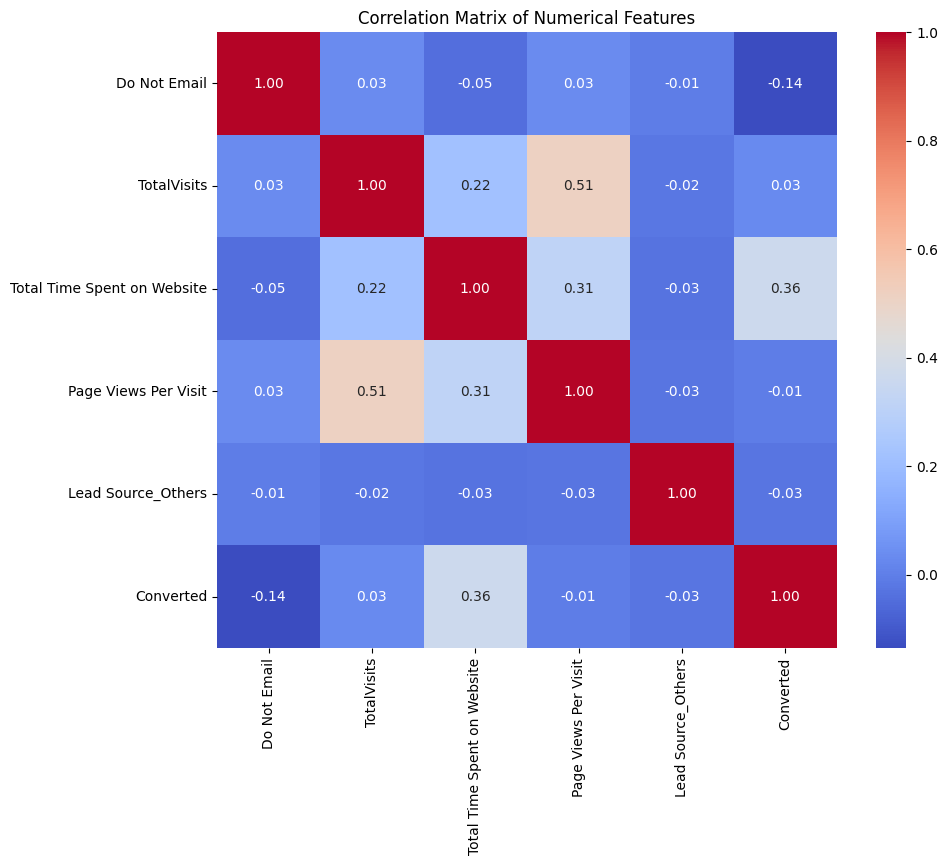

Highly correlated numerical features: set()


In [ ]:

numerical_features = leads_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = leads_df[numerical_features].corr()


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


threshold = 0.75
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

print("Highly correlated numerical features:", correlated_features)


there’s no immediate need to drop numerical variables due to redundancy

**Using RFE to reduce feature set**


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(max_iter=1000, random_state=42)


rfe = RFE(estimator=model, n_features_to_select=20)
X = leads_df[significant_features]
y = leads_df['Converted']

rfe.fit(X, y)

# Identify selected features
selected_features_rfe = X.columns[rfe.support_]
print("Top features selected by RFE:", selected_features_rfe.tolist())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Top features selected by RFE: ['Do Not Email', 'Lead Origin_Lead Add Form', 'Lead Source_Welingak Website', 'Last Activity_Converted to Lead', 'Last Activity_Olark Chat Conversation', 'What is your current occupation_Unemployed', 'What is your current occupation_Working Professional', 'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Interested in Next batch', 'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing', 'Tags_Will revert after reading the email', 'Tags_invalid number', 'Tags_number not provided', 'Tags_switched off', 'Tags_wrong number given', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_SMS Sent']


Scaling the columns

In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
numerical_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
leads_df[numerical_features] = scaler.fit_transform(leads_df[numerical_features])




Re-running RFE after scaling the cols


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Define the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=model, n_features_to_select=20)
X = leads_df[significant_features]
y = leads_df['Converted']

rfe.fit(X, y)

# Identify selected features
selected_features_rfe = X.columns[rfe.support_]
print("Top features selected by RFE:", selected_features_rfe.tolist())

Top features selected by RFE: ['Do Not Email', 'Total Time Spent on Website', 'Lead Origin_Lead Add Form', 'Lead Source_Welingak Website', 'What is your current occupation_Unemployed', 'What is your current occupation_Working Professional', 'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing', 'Tags_Will revert after reading the email', 'Tags_invalid number', 'Tags_number not provided', 'Tags_switched off', 'Tags_wrong number given', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Modified', 'Last Notable Activity_Olark Chat Conversation', 'Last Notable Activity_SMS Sent']


In [ ]:
print("RFE selected features:", selected_features_rfe)
print("Chi-square significant features:", significant_features)
print("RFE features type:", type(selected_features_rfe))
print("Chi-square features type:", type(significant_features))

RFE selected features: Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Welingak Website',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS',
       'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_number not provided', 'Tags_switched off',
       'Tags_wrong number given',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent'],
      dtype='object')
Chi-square significant features: ['Do Not Email', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import', 'Lead Source_Di

In [ ]:
# Use RFE selected features
final_features = list(selected_features_rfe)
leads_df = leads_df[final_features + ['Converted']]  # Include target variable
print(f"Final features for modeling: {final_features}")

Final features for modeling: ['Do Not Email', 'Total Time Spent on Website', 'Lead Origin_Lead Add Form', 'Lead Source_Welingak Website', 'What is your current occupation_Unemployed', 'What is your current occupation_Working Professional', 'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing', 'Tags_Will revert after reading the email', 'Tags_invalid number', 'Tags_number not provided', 'Tags_switched off', 'Tags_wrong number given', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Modified', 'Last Notable Activity_Olark Chat Conversation', 'Last Notable Activity_SMS Sent']


In [ ]:
leads_df

,Do Not Email,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Welingak Website,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Not doing further education,...,Tags_Will revert after reading the email,Tags_invalid number,Tags_number not provided,Tags_switched off,Tags_wrong number given,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_SMS Sent,Converted
0,0,-0.889974,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
1,0,0.339972,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,0,1.905689,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
3,0,-0.333396,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0
4,0,1.715905,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,1,2.476865,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
9236,0,-0.455661,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,0
9237,1,-0.526830,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,0
9238,0,0.020624,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,1


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:

numeric_features = leads_df[final_features].select_dtypes(include=['int64', 'float64']).columns


vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_features
vif_data["VIF"] = [variance_inflation_factor(leads_df[numeric_features].values, i)
                   for i in range(len(numeric_features))]

print(vif_data.sort_values("VIF", ascending=False))

                       Feature       VIF
1  Total Time Spent on Website  1.001984
0                 Do Not Email  1.001984


In [ ]:
# Drop features with high multicollinearity
while True:
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_features
    vif_data["VIF"] = [variance_inflation_factor(leads_df[numeric_features].values, i)
                       for i in range(len(numeric_features))]

    # Find the max VIF
    max_vif = vif_data["VIF"].max()


    if max_vif <= 5:
        break

    # Remove the feature with the highest VIF
    feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
    numeric_features = numeric_features.drop(feature_to_remove)

print("Remaining features after VIF reduction:")
print(numeric_features)

Remaining features after VIF reduction:
Index(['Do Not Email', 'Total Time Spent on Website'], dtype='object')


because no values with high VIF value was there none were dropped



In [ ]:
def combine_sparse_categories(leads_df, threshold=0.05):
    sparse_columns = []

    # Find dummy variable columns
    dummy_columns = leads_df.columns[leads_df.columns.str.contains('_')]

    # Get unique prefixes
    prefixes = set(col.split('_')[0] for col in dummy_columns)

    for col_prefix in prefixes:
        # Get all columns for this category
        category_cols = [col for col in dummy_columns if col.startswith(f"{col_prefix}_")]

        # Calculate sparsity
        sparsity_series = leads_df[category_cols].sum()
        total_sparse = sparsity_series[sparsity_series < threshold * len(leads_df)]

        # If multiple sparse columns exist
        if len(total_sparse) > 1:

            sparse_category_cols = total_sparse.index.tolist()

            #
            leads_df[f'{col_prefix}_Other'] = leads_df[sparse_category_cols].any(axis=1).astype(int)


            leads_df = leads_df.drop(columns=sparse_category_cols)

            sparse_columns.extend(sparse_category_cols)

    return leads_df, sparse_columns


leads_df, combined_sparse_columns = combine_sparse_categories(leads_df)

print("Combined sparse columns:", combined_sparse_columns)

Combined sparse columns: ['Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_invalid number', 'Tags_number not provided', 'Tags_switched off', 'Tags_wrong number given', 'Last Notable Activity_Had a Phone Conversation', 'Last Notable Activity_Olark Chat Conversation']


In [ ]:
leads_df

,Do Not Email,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Welingak Website,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Ringing,Tags_Will revert after reading the email,Last Notable Activity_Modified,Last Notable Activity_SMS Sent,Converted,Tags_Other,Last Notable Activity_Other
0,0,-0.889974,False,False,True,False,False,False,True,False,0,0,0
1,0,0.339972,False,False,True,False,True,False,False,False,0,0,0
2,0,1.905689,False,False,False,False,False,True,False,False,1,0,0
3,0,-0.333396,False,False,True,False,True,False,True,False,0,0,0
4,0,1.715905,False,False,True,False,False,True,True,False,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,1,2.476865,False,False,True,False,False,True,False,False,1,0,0
9236,0,-0.455661,False,False,True,False,False,False,False,True,0,1,0
9237,1,-0.526830,False,False,True,False,False,False,False,True,0,1,0
9238,0,0.020624,False,False,True,False,False,True,False,True,1,0,0


##Part5: Model Building

In [ ]:
from sklearn.model_selection import train_test_split

# Define the feature matrix X and the target vector y
X = leads_df.drop(columns=['Converted'])
y = leads_df['Converted']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (6468, 12)
Testing set shape: (2772, 12)


In [ ]:
# Import the Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Instantiate the model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
logreg.fit(X_train, y_train)

# Display the model's coefficients for each feature
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logreg.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)


                                              Feature  Coefficient
2                           Lead Origin_Lead Add Form     3.645472
7            Tags_Will revert after reading the email     3.145750
10                                         Tags_Other     2.879779
9                      Last Notable Activity_SMS Sent     1.808257
5   What is your current occupation_Working Profes...     1.523548
1                         Total Time Spent on Website     1.025921
3                        Lead Source_Welingak Website     0.987057
8                      Last Notable Activity_Modified    -0.615122
11                        Last Notable Activity_Other    -0.765344
4          What is your current occupation_Unemployed    -1.135490
6                                        Tags_Ringing    -1.148978
0                                        Do Not Email    -1.816047


In [ ]:
# Check data types of features in X_train
print("Data types in X_train:")
print(X_train.dtypes)

# Check data type of the target variable y_train
print("\nData type of y_train:")
print(y_train.dtypes)


Data types in X_train:
Do Not Email                                              int64
Total Time Spent on Website                             float64
Lead Origin_Lead Add Form                                  bool
Lead Source_Welingak Website                               bool
What is your current occupation_Unemployed                 bool
What is your current occupation_Working Professional       bool
Tags_Ringing                                               bool
Tags_Will revert after reading the email                   bool
Last Notable Activity_Modified                             bool
Last Notable Activity_SMS Sent                             bool
Tags_Other                                                int64
Last Notable Activity_Other                               int64
dtype: object

Data type of y_train:
int64


In [ ]:
# Convert boolean columns to integers
X_train_processed = X_train.select_dtypes(include=['bool']).astype(int)

# Add numeric columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64'])
X_train_processed = pd.concat([X_train_processed, numeric_columns], axis=1)

In [ ]:
# Re-check data types to confirm
print("Updated data types in X_train:")
print(X_train_processed.dtypes)


Updated data types in X_train:
Lead Origin_Lead Add Form                                 int64
Lead Source_Welingak Website                              int64
What is your current occupation_Unemployed                int64
What is your current occupation_Working Professional      int64
Tags_Ringing                                              int64
Tags_Will revert after reading the email                  int64
Last Notable Activity_Modified                            int64
Last Notable Activity_SMS Sent                            int64
Do Not Email                                              int64
Total Time Spent on Website                             float64
Tags_Other                                                int64
Last Notable Activity_Other                               int64
dtype: object


In [ ]:
# Convert to numpy arrays
X_train_sm = sm.add_constant(X_train_processed)
y_train_array = y_train


logm2 = sm.GLM(y_train_array, X_train_sm, family=sm.families.Binomial())
res = logm2.fit()

# model summary
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2129.3
Date:                Tue, 19 Nov 2024   Deviance:                       4258.7
Time:                        04:57:56   Pearson chi2:                 8.87e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4908
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [ ]:
X_train_sm.drop('Lead Source_Welingak Website', axis = 1, inplace = True)

In [ ]:
logm2 = sm.GLM(y_train_array, X_train_sm, family=sm.families.Binomial())
res = logm2.fit()

# model summary
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6456
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2131.5
Date:                Tue, 19 Nov 2024   Deviance:                       4262.9
Time:                        04:57:56   Pearson chi2:                 9.04e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4905
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

##Part6: Model Evaluation

In [ ]:
print("Model exog shape:", res.model.exog.shape)
print("X_train shape:", X_train.shape)

Model exog shape: (6468, 12)
X_train shape: (6468, 12)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Define and fit the logistic regression model
model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Generate Predictions
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_prob >= 0.5).astype(int)  #(threshold = 0.5)


In [ ]:
# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.8586
Precision: 0.8231
Recall: 0.8062
F1-Score: 0.8146
ROC-AUC: 0.9175


**Threshold Optimization**

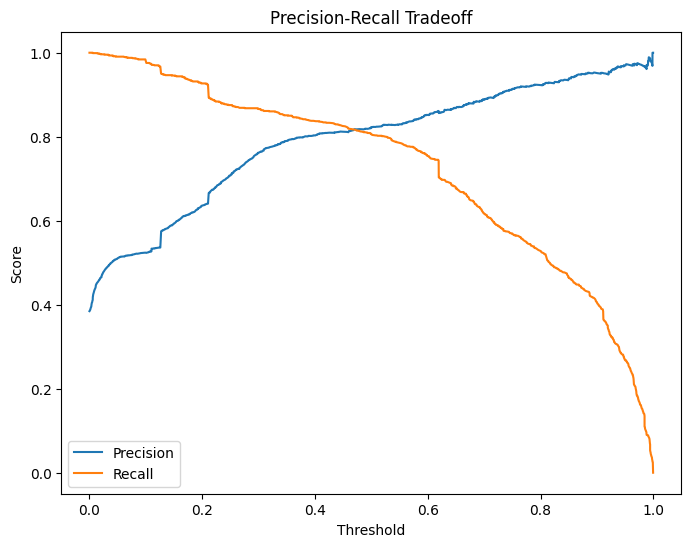

In [ ]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_vals[:-1], label="Precision")
plt.plot(thresholds, recall_vals[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import f1_score

f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals)
best_threshold = thresholds[f1_scores.argmax()]

print(f"Optimal Threshold: {best_threshold}")


Optimal Threshold: 0.40788371587535494


In [ ]:
# Apply optimal threshold to classify
y_pred_class_optimal = (y_pred_prob >= 0.4079).astype(int)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Recalculate metrics
accuracy = accuracy_score(y_test, y_pred_class_optimal)
precision = precision_score(y_test, y_pred_class_optimal)
recall = recall_score(y_test, y_pred_class_optimal)
f1 = f1_score(y_test, y_pred_class_optimal)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.8600
Precision: 0.8080
Recall: 0.8352
F1-Score: 0.8214
ROC-AUC: 0.9175



Metrics at Different Probability Thresholds:
   Threshold  Accuracy  Sensitivity  Specificity
0        0.1     0.649        0.976        0.444
1        0.2     0.768        0.927        0.668
2        0.3     0.845        0.866        0.831
3        0.4     0.858        0.837        0.871
4        0.5     0.859        0.806        0.891
5        0.6     0.855        0.754        0.918
6        0.7     0.823        0.617        0.952
7        0.8     0.801        0.528        0.972
8        0.9     0.763        0.406        0.987


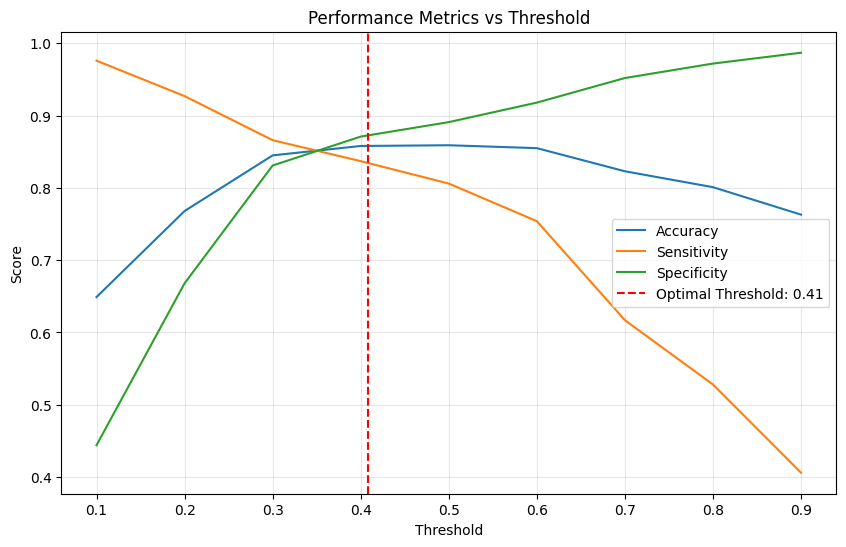

In [ ]:
# Create a function to calculate metrics at different thresholds
def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # Also called recall
    specificity = tn / (tn + fp)

    return accuracy, sensitivity, specificity

# Create a range of thresholds
thresholds = np.arange(0.1, 1.0, 0.1)

# Calculate metrics for each threshold
results = []
for threshold in thresholds:
    acc, sens, spec = calculate_metrics(y_test, y_pred_prob, threshold)
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Sensitivity': sens,
        'Specificity': spec
    })

# Convert to DataFrame for better visualization
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.round(3)  # Round to 3 decimal places

# Display the results
print("\nMetrics at Different Probability Thresholds:")
print(metrics_df)

# Optional: Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy')
plt.plot(metrics_df['Threshold'], metrics_df['Sensitivity'], label='Sensitivity')
plt.plot(metrics_df['Threshold'], metrics_df['Specificity'], label='Specificity')
plt.axvline(0.4079, color='red', linestyle='--', label=f'Optimal Threshold: {0.4079:.2f}')
plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
##0.41 is still being kept as threshold because  it provides the best balance between correctly identifying both positive and negative cases

In [ ]:
# from sklearn.metrics import precision_recall_curve

# # Calculate precision, recall, and thresholds
# precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_prob)

# # Create the plot
# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, precision_vals[:-1], label='Precision')
# plt.plot(thresholds, recall_vals[:-1], label='Recall')
# plt.axvline(0.4079, color='red', linestyle='--', label=f'Optimal Threshold: {0.4079:.2f}')
# plt.title('Precision-Recall Tradeoff')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

In [ ]:
optimal_threshold = 0.41
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print("Metrics at Optimal Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print("Confusion Matrix:")
print(cm)

Metrics at Optimal Threshold:
Accuracy: 0.8600
Precision: 0.8080
Recall: 0.8352
F1-Score: 0.8214
Confusion Matrix:
[[1492  212]
 [ 176  892]]


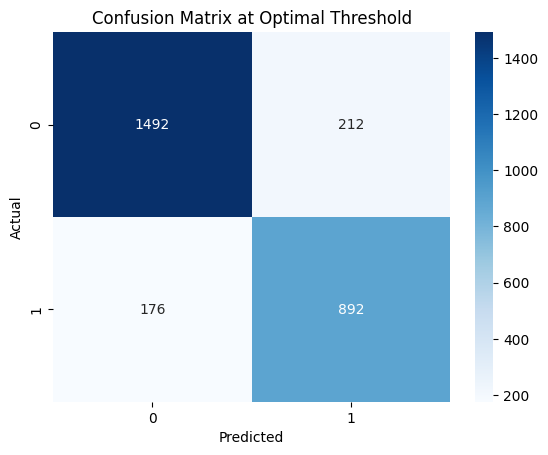

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix at Optimal Threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


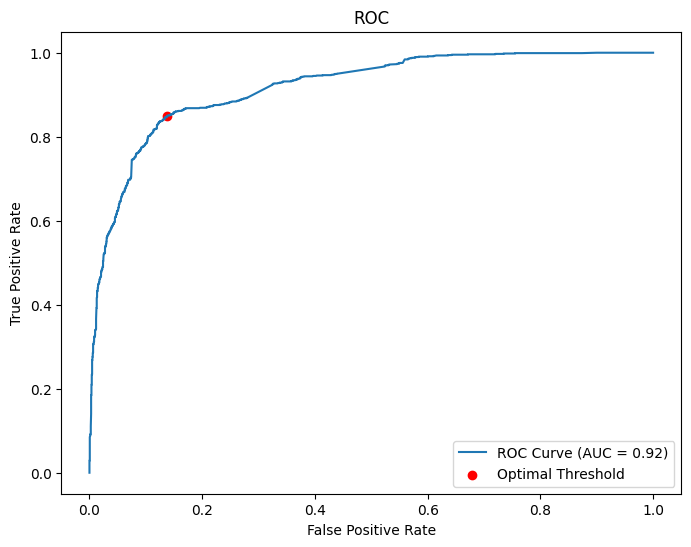

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], color='red', label='Optimal Threshold')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


 (AUC) of 0.92 suggests very good predictive performance

In [ ]:
print("Model exog shape:", res.model.exog.shape)
print("X_test shape:", X_test.shape)

Model exog shape: (6468, 12)
X_test shape: (2772, 12)


In [ ]:
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

Precision: 0.8080
Recall: 0.8352
F1-Score: 0.8214


In [ ]:
y_pred_optimal

array([0, 1, 1, ..., 0, 1, 1])

**Predction Check**

In [ ]:
# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_optimal,
    'Probability': y_pred_prob
})


print("\nComparison of Actual vs Predicted values (first 10 rows):")
print(comparison_df.head(10))



Comparison of Actual vs Predicted values (first 10 rows):
      Actual  Predicted  Probability
8305       0          0     0.210517
1591       1          1     0.663630
8604       0          1     0.629338
1333       0          0     0.258237
4260       0          0     0.001970
2357       1          1     0.964529
1900       1          1     0.726177
9077       0          0     0.016143
6302       1          1     0.705110
8158       1          0     0.125985


In [ ]:
# Display top positive and negative coefficients
top_positive_features = coefficients[coefficients['Coefficient'] > 0].head(7)
top_negative_features = coefficients[coefficients['Coefficient'] < 0].head(7)

print("\nTop Positive Features Driving Conversion:")
print(top_positive_features)

print("\nTop Negative Features Reducing Conversion:")
print(top_negative_features)



Top Positive Features Driving Conversion:
                                              Feature  Coefficient
2                           Lead Origin_Lead Add Form     3.645472
7            Tags_Will revert after reading the email     3.145750
10                                         Tags_Other     2.879779
9                      Last Notable Activity_SMS Sent     1.808257
5   What is your current occupation_Working Profes...     1.523548
1                         Total Time Spent on Website     1.025921
3                        Lead Source_Welingak Website     0.987057

Top Negative Features Reducing Conversion:
                                       Feature  Coefficient
8               Last Notable Activity_Modified    -0.615122
11                 Last Notable Activity_Other    -0.765344
4   What is your current occupation_Unemployed    -1.135490
6                                 Tags_Ringing    -1.148978
0                                 Do Not Email    -1.816047


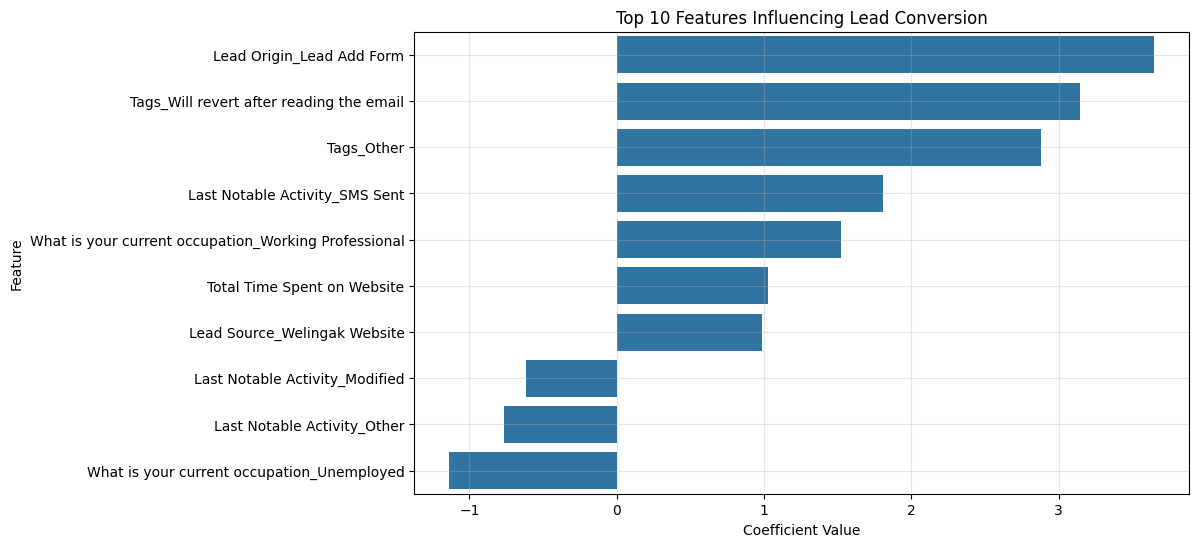

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(10))
plt.title('Top 10 Features Influencing Lead Conversion')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)
plt.show()
